# Train AE with data generated on MullerBrown potential 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.EntropicSwitchTrippleWellPotential import EntropicSwitchTrippleWellPotential
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [4]:
pot = EntropicSwitchTrippleWellPotential()

In [5]:
beta = 2
dt = 0.01
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**5

In [7]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [8]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [9]:
trajs = np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)
#np.savetxt('dataset_ES.txt', trajs)

In [ ]:
trajs = np.loadtxt('dataset_ES.txt')
trajs = trajs[np.random.choice(len(trajs), size=2 * 10**6)]

In [11]:
dataset = {"boltz_points": trajs}

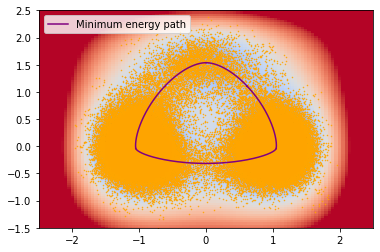

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.plot(pot.minimum_energy_paths[2][:, 0], pot.minimum_energy_paths[2][:, 1], color='purple')
ax.scatter(trajs[:, 0], trajs[:, 1], marker=".", color="orange", s=1)
ax.legend()

In [13]:
dataset.keys()

dict_keys(['boltz_points'])

Import AE model 

In [14]:
from autoencoders.ae_models import DeepAutoEncoderDoubleDec
from autoencoders.train_aes import TainAETwoDecoder

Create autoencoder object

In [27]:
del(ae)
del(ae_training)

In [28]:
ae = DeepAutoEncoderDoubleDec([2, 5, 1], [1, 20, 20, 2], 0)

Created training object

In [29]:
ae_training = TainAETwoDecoder(ae, pot, dataset.copy(), standardize=False)

Set the training size and do the train-test split

In [30]:
ae_training.train_test_split(train_size=2 * 10**3)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)

Set the optimizer 

In [31]:
ae_training.set_optimizer('Adam', 0.001, parameters_to_train='all')

Set the loss function parameters 

In [32]:
loss_params = {}
loss_params["mse_boltz_weight"] = 1.0 * 10**(0)
loss_params["var_enc_weight"] = 1.0 * 10**(0)
loss_params["squared_grad_boltz_weight"] = 1.0 * 10**(-4)
loss_params["pen_points_weight"] = 0.0 * 10**(-1)
loss_params["pen_points_mse_weight"] = 0.0 * 10**(-1)
loss_params["n_wait"] = 50
ae_training.set_loss_weight(loss_params)

mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [33]:
batch_size = 100
max_epochs = 10000

Train 

In [34]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 1343 epochs.



Plot the evolution of the loss stating from the 100th epoch 

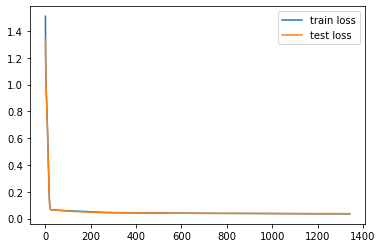

In [35]:
plt.figure()
plt.plot(loss_dict["train_loss"][:], label='train loss')
plt.plot(loss_dict["test_loss"][:], label='test loss')
plt.legend()

Plot the conditionnal averages on the potential heat map 

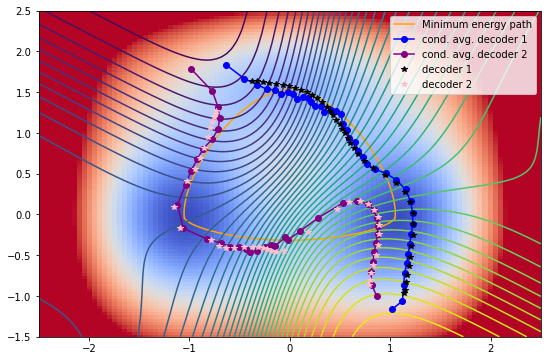

In [36]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.plot(pot.minimum_energy_paths[2][:, 0], pot.minimum_energy_paths[2][:, 1], color='orange')
ae_training.plot_encoder_iso_levels(ax, 40)
ae_training.plot_conditional_averages(ax, 40)
ae_training.plot_conditional_averages
ax.legend()

Plot convergence of the principal curve 

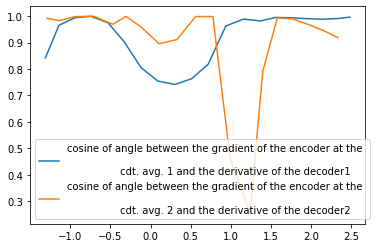

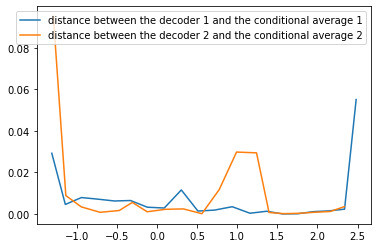

In [37]:
ae_training.plot_principal_curve_convergence(20)

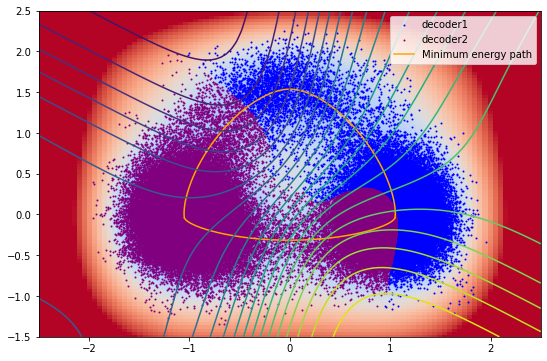

In [38]:
import torch 
boltz_points = torch.tensor(ae_training.dataset["boltz_points"].astype('float32'))
boltz_points_decoded1 = ae_training.ae.decoder1(ae_training.ae.encoder(boltz_points))
boltz_points_decoded2 = ae_training.ae.decoder2(ae_training.ae.encoder(boltz_points))
x1 = torch.sum((boltz_points - boltz_points_decoded1) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded2) ** 2,
            dim=1).detach().numpy()
x2 = torch.sum((boltz_points - boltz_points_decoded2) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded1) ** 2,
            dim=1).detach().numpy()

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.scatter(ae_training.dataset["boltz_points"][x1][:, 0], ae_training.dataset["boltz_points"][x1][:, 1], color='blue', label='decoder1', s=1)
ax.scatter(ae_training.dataset["boltz_points"][x2][:, 0], ae_training.dataset["boltz_points"][x2][:, 1], color='purple', label='decoder2', s=1)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.plot(pot.minimum_energy_paths[2][:, 0], pot.minimum_energy_paths[2][:, 1], color='orange')

ae_training.plot_encoder_iso_levels(ax, 20)
ax.legend()

In [39]:
ae_training.print_test_loss()

Test loss:  tensor(0.0387, grad_fn=<AddBackward0>)
Test MSE Boltzmann:  tensor(0.0386, grad_fn=<MeanBackward0>)
Test squarred grad encoder:  tensor(0.5712, grad_fn=<MeanBackward0>)
